Load up the packages

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
import os
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

In [343]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [344]:
data = pd.read_csv('gun-violence-data.csv')

Convert labels to object type since they're really numeric labels

In [345]:
to_objs = ['incident_id', 'state_house_district', 'state_senate_district', 'congressional_district']
data[to_objs] = data[to_objs].astype('object')


Remove unuseful fields - more work than they seem worth for now 

In [346]:
to_omit = ['address', 'incident_url', 'source_url','incident_url_fields_missing', 'participant_relationship',
'participant_age_group', 'participant_name', 'sources', 'location_description', 'gun_stolen']
data.drop(columns = to_omit,inplace=True)

In [347]:
data['date']= data['date'].astype('datetime64[ns]')

Notes about dataset from info:

- *incident_id, state_house_district, state_senate_district, congressional_district* need to be changed to object type since they are labels.
- *date* needs to be datetype
- Omitted for now: *address, incident_url, source_url, incident_url_fields_missing, participant_age_group, participant_name, sources*
- text processing for *gun_stolen, gun_type, incident_characteristics, location_description, notes, participant_gender, participant_relationship, participant_type, participant_status*

In [348]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 19 columns):
incident_id                 239677 non-null object
date                        239677 non-null datetime64[ns]
state                       239677 non-null object
city_or_county              239677 non-null object
n_killed                    239677 non-null int64
n_injured                   239677 non-null int64
congressional_district      227733 non-null object
gun_type                    140226 non-null object
incident_characteristics    239351 non-null object
latitude                    231754 non-null float64
longitude                   231754 non-null float64
n_guns_involved             140226 non-null float64
notes                       158660 non-null object
participant_age             147379 non-null object
participant_gender          203315 non-null object
participant_status          212051 non-null object
participant_type            214814 non-null object
state_house_d

replace Nan's in n_guns_involved with '1' because at least 1 gun needed to be involved to be included in the dataset.

In [349]:
data.n_guns_involved.fillna(1, inplace=True)
data.gun_type.fillna('Unknown', inplace=True)
data.notes.fillna('None', inplace = True)
data.dropna(inplace=True)

In [350]:
data.isnull().sum() / len(data) * 100

incident_id                0.000
date                       0.000
state                      0.000
city_or_county             0.000
n_killed                   0.000
n_injured                  0.000
congressional_district     0.000
gun_type                   0.000
incident_characteristics   0.000
latitude                   0.000
longitude                  0.000
n_guns_involved            0.000
notes                      0.000
participant_age            0.000
participant_gender         0.000
participant_status         0.000
participant_type           0.000
state_house_district       0.000
state_senate_district      0.000
dtype: float64

In [351]:
data.shape

(121427, 19)

In [352]:
data['participant_gender'].replace('([0-9]+)(::)','',regex=True, inplace=True)
data['participant_status'].replace('([0-9]+)(::)','',regex=True, inplace=True)
data['participant_type'].replace('([0-9]+)(::)','',regex=True, inplace=True)
data['participant_age'].replace('([0-9]+)(::)','',regex=True, inplace=True)
data['gun_type'].replace('([0-9]+)(::)','',regex=True, inplace=True)
data['incident_characteristics'].replace('||','', inplace=True)


In [353]:
cv_gender = TfidfVectorizer(input = 'content', vocabulary = ['male','female'])
pt_gender = cv_gender.fit_transform(data.participant_gender).toarray()
gender_df = pd.DataFrame(pt_gender, columns = cv_gender.vocabulary_)

In [354]:
cv_status = TfidfVectorizer(input = 'content', vocabulary = ['killed','injured','unharmed','arrested'])
pt_status = cv_status.fit_transform(data.participant_status).toarray()
status_df = pd.DataFrame(pt_status, columns = cv_status.vocabulary_)

In [355]:
cv_type = TfidfVectorizer(input = 'content', vocabulary = ['victim','subject','suspect'])
pt_type = cv_type.fit_transform(data.participant_type).toarray()
type_df = pd.DataFrame(pt_type, columns = cv_type.vocabulary_)

In [356]:
cv_ic = TfidfVectorizer(input = 'content')
ic = cv_ic.fit_transform(data.incident_characteristics).toarray()
ic_df = pd.DataFrame(ic, columns = cv_ic.vocabulary_)

In [357]:
cv_gun_type = TfidfVectorizer(input = 'content')
gt = cv_gun_type.fit_transform(data.incident_characteristics).toarray()
gt_df = pd.DataFrame(gt, columns = cv_gun_type.vocabulary_)

In [358]:
data = pd.concat((data,type_df,status_df, gender_df,ic_df,gt_df), axis=1)

In [359]:
data.drop(['participant_gender','participant_status','participant_type',
           'incident_characteristics','gun_type','participant_age'],axis=1,inplace=True)

In [360]:
data.dropna(inplace=True)

In [361]:
num_data = data.select_dtypes(include = ['float64','int64'])

In [362]:
freq = np.ravel(num_data.sum(axis=0))

In [365]:
gt_df.loc[-1] = np.ravel(gt_df.sum(axis=0))

In [374]:
sorted(set(list(zip(gt_df.loc[-1],gt_df.columns))),key=list,reverse=True)

[(22053.280322815273, 'police'),
 (19081.08420292414, 'crime'),
 (18806.097813515687, 'political'),
 (13821.495961181157, 'surrender'),
 (13733.317963726786, 'murder'),
 (12872.274148957838, 'pistol'),
 (12436.331231605845, 'violence'),
 (7103.435688389231, 'during'),
 (6802.66401333592, 'unlawful'),
 (6278.318487845455, 'picked'),
 (6246.968891522004, 'institution'),
 (6002.252736784144, 'college'),
 (5798.4691072929145, 'unloaded'),
 (5562.390204991068, 'abductions'),
 (4739.682218426805, 'hunting'),
 (4718.092156409535, 'victim'),
 (4706.302403463088, 'by'),
 (4439.4098929054735, 'purchase'),
 (4397.19144696973, 'atf'),
 (4295.500790466045, 'non'),
 (4140.9010915227955, 'unsuccessful'),
 (4140.9010915227955, 'only'),
 (4140.9010915227955, 'accident'),
 (4032.409326517169, 'shoots'),
 (3848.2665075531586, 'prohibited'),
 (3824.587010361317, 'targeted'),
 (3689.147145534578, 'drug'),
 (3584.235057448425, 'diagram'),
 (3340.3747888184457, 'house'),
 (3242.6746096043967, 'party'),
 (306

In [366]:
ic_df.loc[-1] = np.ravel(ic_df.sum(axis=0))

In [ ]:
sorted(set(list(zip(ic_df.loc[-1],ic_df.columns))),key=list,reverse=True)

In [375]:
status_df.loc[-1] = np.ravel(status_df.sum(axis=0))

In [376]:
sorted(set(list(zip(status_df.loc[-1],status_df.columns))),key=list,reverse=True)

[(142368.35654471428, 'unharmed'),
 (125593.8427365374, 'injured'),
 (104966.898871841, 'arrested'),
 (94120.8902901404, 'killed')]

In [377]:
type_df.loc[-1] = np.ravel(type_df.sum(axis=0))

In [378]:
sorted(set(list(zip(type_df.loc[-1],type_df.columns))),key=list,reverse=True)

[(195344.37055416574, 'victim'),
 (159475.47304251487, 'suspect'),
 (159475.47304251487, 'subject')]

In [238]:
from statsmodels.distributions.empirical_distribution import ECDF

In [322]:
a = ECDF(data['n_killed'])
b = ECDF(data['n_guns_involved'])

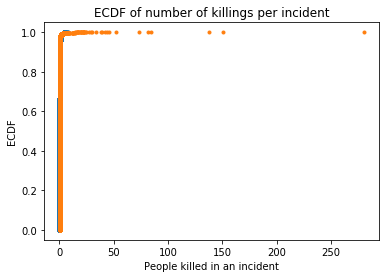

In [323]:
plt.plot(a.x, a.y, marker = '.', linestyle = 'none')
plt.plot(b.x, b.y, marker = '.', linestyle = 'none')

plt.xlabel('People killed in an incident')
plt.ylabel('ECDF')
plt.title('ECDF of number of killings per incident')
plt.show()